In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

In [ ]:
#india_labelled=pd.read_csv('/kaggle/input/final-proj/unitedkingdom_labelled.csv')
india_labelled=pd.read_csv('/kaggle/input/final-proj/MiddleEast_labelled2.csv')

In [ ]:
india_labelled

In [ ]:
india_labelled.results.value_counts()

In [ ]:
df = india_labelled

In [ ]:
df=df.dropna()

In [ ]:
df

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [ ]:
df['comments'] = df['comments'].apply(remove_stopwords)

print(df.head())

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Assuming your DataFrame is named df and the comments are in the 'comments' column
comments = df['comments']

# Convert comments to a bag-of-words representation
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(comments)

# Fit an LDA model
num_topics = 5  # You can adjust this based on your requirements
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Get the topics and their associated words
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_features_idx = topic.argsort()[:-10 - 1:-1]
    top_features = [feature_names[i] for i in top_features_idx]
    topics.append((topic_idx, top_features))

# Display the topics
for topic_idx, top_features in topics:
    print(f"Topic #{topic_idx + 1}: {', '.join(top_features)}")

# Assign a topic to each comment
topic_assignments = lda.transform(X).argmax(axis=1)
df['topic'] = topic_assignments

# Display the DataFrame with topics
print(df[['comments', 'topic']])


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Assuming your DataFrame is named df and the comments are in the 'comments' column
comments = df['comments']

# Convert comments to a bag-of-words representation
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(comments)

# Define seed words for Israel and Palestine
israel_seed = ["israel", "idf", "jerusalem", "tel aviv", "netanyahu","jew"]
palestine_seed = ["palestine", "gaza", "west bank", "hamas", "abbas",'ceasefire','peace']

# Set up LDA model with 2 topics
num_topics = 2
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit LDA model with seed words
lda.fit(X)

# Get the topics and their associated words
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_features_idx = topic.argsort()[:-10 - 1:-1]
    top_features = [feature_names[i] for i in top_features_idx]
    topics.append((topic_idx, top_features))

# Display the topics
for topic_idx, top_features in topics:
    print(f"Topic #{topic_idx + 1}: {', '.join(top_features)}")

# Assign a topic to each comment
topic_assignments = lda.transform(X).argmax(axis=1)
df['topic'] = topic_assignments

# Display the DataFrame with topics
print(df[['comments', 'topic']])


In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Assuming your DataFrame is named df and the comments are in the 'comments' column
comments = df['comments']

# Initialize the VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each comment
sentiment_scores = comments.apply(lambda x: sid.polarity_scores(x))

# Extract compound scores (a normalized, weighted composite score)
df['compound_score'] = sentiment_scores.apply(lambda x: x['compound'])

# Classify sentiment based on the compound score
df['sentiment'] = df['compound_score'].apply(lambda score: 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral')

# Display the DataFrame with sentiment analysis results
print(df[['comments', 'compound_score', 'sentiment']])


In [ ]:
israel_word_index = vectorizer.vocabulary_['israel']
palestine_word_index = vectorizer.vocabulary_['palestine']

In [ ]:
topic_term_distribution = lda.components_

In [ ]:
topic_term_distribution

In [ ]:
israel_topic_index = topic_term_distribution[:, israel_word_index].argmax()
palestine_topic_index = topic_term_distribution[:, palestine_word_index].argmax()

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Assuming your DataFrame is named df and the comments are in the 'clean_text' column
comments = df['comments']

# Initialize the VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each comment
df['Compound'] = comments.apply(lambda x: sid.polarity_scores(x)['compound'])

# Assuming you already have lda_model, vectorizer, israel_topic_index, and palestine_topic_index

def determine_geopolitical_stance(row):
    sentiment_score = row['Compound']
    topic_distribution = lda.transform(vectorizer.transform([row['comments']]))[0]
    
    # Determine stance based on sentiment score and dominant topic
    if sentiment_score <= -0.5:
        return 'Against Israel/Palestine'
    elif sentiment_score >= 0.5 and topic_distribution.argmax() == israel_topic_index:
        return 'Supports Israel'
    elif sentiment_score >= 0.5 and topic_distribution.argmax() == palestine_topic_index:
        return 'Supports Palestine'
    else:
        return 'Neutral/Stance Not Clear'

# Apply the function to the DataFrame to determine geopolitical stances
df['geopolitical_stance'] = df.apply(determine_geopolitical_stance, axis=1)

# Display the DataFrame with geopolitical stances
print(df[['comments', 'Compound', 'geopolitical_stance']])


In [ ]:
df['geopolitical_stance'].value_counts()

In [ ]:
df[(df['geopolitical_stance'] == 'Supports Israel') & (df['results'] != -1)].loc[20].comments


In [ ]:
import pandas as pd

# Assuming your DataFrame is named df and the comments are in the 'comments' column
comments = df['comments']

# Create a new column indicating the topic
df['topic'] = None

# Check for mentions of both Israel and Palestine
df.loc[comments.str.contains('israel', case=False) & ~comments.str.contains('palestine', case=False), 'topic'] = 'Israel'
df.loc[comments.str.contains('palestine', case=False) & ~comments.str.contains('israel', case=False), 'topic'] = 'Palestine'

# Identify comments mentioning both Israel and Palestine
both_topics_mask = comments.str.contains('israel', case=False) & comments.str.contains('palestine', case=False)

# Analyze the frequency to determine the main subject
df.loc[both_topics_mask, 'topic'] = None  # Initialize as None
df.loc[both_topics_mask, 'topic'] = df.loc[both_topics_mask, 'comments'].apply(
    lambda comment: 'Israel' if comment.lower().count('israel') > comment.lower().count('palestine') else 'Palestine'
)

# Display the DataFrame with topics
print(df[['comments', 'topic']])


In [ ]:
df['topic'].value_counts()

In [ ]:
palestine_topic_index

In [ ]:
askindia_labelled=pd.read_csv('/kaggle/input/final-project/AskIndia_labelled_final_v2.csv')

In [ ]:
askindia_labelled

In [ ]:
askindia_labelled.results.value_counts()

In [ ]:
df = pd.concat([askindia_labelled, india_labelled], ignore_index=True)

In [ ]:
df = india_labelled

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df=df.dropna()

In [ ]:
df= df[df['results'] != 0]

In [ ]:
df.head()

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [ ]:
df['comments'] = df['comments'].apply(remove_stopwords)

print(df.head())

In [ ]:
df_india = pd.read_csv('/kaggle/input/final-proj/india_gpt_labelled.csv')
df_usa = pd.read_csv('/kaggle/input/final-proj/America_final_labelled.csv')
df_japan = pd.read_csv('/kaggle/input/final-proj/Japan_labelled_final.csv')
df_canada = pd.read_csv('/kaggle/input/final-proj/canada_gpt_labelled.csv')
df_middle_east = pd.read_csv('/kaggle/input/final-proj/MiddleEast_labelled2.csv')

In [ ]:
df_japan

In [ ]:
df_usa['results_True'].value_counts()

In [ ]:
df = pd.read_csv('/kaggle/input/final-proj/MiddleEast_labelled2.csv')

df1 = df.copy()
df.head()

In [ ]:
#df = df_usa
df.head()

In [ ]:
df=df.dropna()

In [ ]:
df = df_india 

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(df['cleaned_comments'], df['actual_label'], test_size=0.2, random_state=69)

In [ ]:
df=df.dropna()

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000,stop_words = 'english')
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

In [ ]:
train_data.head()

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(train_vectors, train_labels)

In [ ]:
predictions = classifier.predict(test_vectors)
print("Accuracy:", accuracy_score(test_labels, predictions))
print("\nClassification Report:\n", classification_report(test_labels, predictions))
accuracy_score_log = accuracy_score(test_labels, predictions)

In [ ]:
df['results'].value_counts()

In [ ]:
# Count occurrences when 'results' is equal to 'actual_label' and group by labels
count_by_label = df[df['results'] == df['actual_label']]['results'].value_counts()

# Display the counts
print("Count of correct predictions by label:")
print(count_by_label)

In [ ]:
df

In [ ]:
df['actual_label'].value_counts()

In [ ]:
predictions_df = pd.DataFrame({'Predictions': predictions})
predictions_df.value_counts()

In [ ]:
#India predicted 40 Neutral opinions in Test set

In [ ]:
classifiernb = MultinomialNB(alpha=0.1)
classifiernb.fit(train_vectors, train_labels)

In [ ]:
predictions = classifiernb.predict(test_vectors)

In [ ]:
print("Accuracy:", accuracy_score(test_labels, predictions))
print("\nClassification Report:\n", classification_report(test_labels, predictions))

accuracy_score_nb = accuracy_score(test_labels, predictions)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_model = xgb.XGBClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model to the data
grid_search.fit(train_vectors, train_labels+1)


In [ ]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)
accuracy_score_xgb = grid_search.best_score_

In [ ]:
gpt_error = (df1['manual_labels'] == df1['gpt_labels']).mean() 
print(gpt_error)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have three accuracy scores: accuracy_score_xgb, accuracy_score_log, accuracy_score_nb
accuracies = [accuracy_score_xgb, accuracy_score_log, accuracy_score_nb,gpt_error]
models = ['XGB', 'Logistic Regression', 'Naive Bayes', 'GPT 3.5 Turbo']

# Create a DataFrame for seaborn
data = {'Model': models, 'Accuracy': accuracies}
df = pd.DataFrame(data)

# Create a bar plot
sns.set(style="whitegrid")  # Optional: Set a seaborn style
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Create a bar plot
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')
plt.title('Model Accuracies for Canada')
plt.ylim(0, 1)  # Assuming accuracy ranges from 0 to 1

# Save the figure as a high-definition image (e.g., PNG)
plt.savefig('model_accuracies_Canada_final.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
df.head()

In [ ]:
df_india = pd.read_csv('/kaggle/input/final-proj/india_gpt_labelled.csv')
df_usa = pd.read_csv('/kaggle/input/final-proj/America_final_labelled.csv')
df_japan = pd.read_csv('/kaggle/input/final-proj/Japan_labelled_final.csv')
df_canada = pd.read_csv('/kaggle/input/final-proj/canada_gpt_labelled.csv')
df_middle_east = pd.read_csv('/kaggle/input/final-proj/MiddleEast_labelled2.csv')

In [ ]:
df1.head()

In [ ]:
df

In [ ]:
gpt_error = (df1['results_True'] == df1['results_chatgpt']).mean() 

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have calculated gpt_error
gpt_error = (df1['actual_label'] == df1['results']).mean() * 100

# Create a pie chart
labels = ['Correct Predictions', 'Incorrect Predictions']
sizes = [gpt_error, 100-gpt_error]
colors = ['#63c2de', '#ff9999']  # Blue for correct, Red for incorrect

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('GPT Error')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Save the pie chart as an image (e.g., PNG)
plt.savefig('gpt_error_pie_chart.png', dpi=300, bbox_inches='tight')

# Show the pie chart
plt.show()


In [ ]:
incorrect_predictions = df1[(df1['results'] == 1) & (df1['actual_label'] != 1)]
print(incorrect_predictions)

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for cases where results is predicted as 1 and actual_label is -1
incorrect_predictions = df1[(df1['results'] == 1) & (df1['actual_label'] != 1)]

# Calculate the percentage of such incorrect predictions
incorrect_percentage = (len(incorrect_predictions) / len(df1)) * 100

# Create a pie chart for these incorrect predictions
labels = ['Incorrect Predictions', 'Correct Predictions']
sizes = [100 - incorrect_percentage, incorrect_percentage]
colors = ['#63c2de', '#ff9999']  # Blue for correct, Red for incorrect

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('GPT predicting Palestine')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Save the pie chart as an image (e.g., PNG)
plt.savefig('incorrect_predictions_pie_chart.png', dpi=300, bbox_inches='tight')

# Show the pie chart
plt.show()


In [ ]:
coefs = None
features = None
classes = None

coefs = classifier.coef_
features = vectorizer.get_feature_names_out()
classes = classifier.classes_

In [ ]:
coef_df = pd.DataFrame(data=coefs.T, index=features, columns=classes)
display(coef_df)

In [ ]:
#most predictive words
print(coef_df[-1].sort_values(ascending=False).head(10))

In [ ]:
print(coef_df[1].sort_values(ascending=False).head(10))

In [ ]:
test_labels

In [ ]:
pred_df = pd.DataFrame({'pred': predictions, 'label': test_labels})
display(pred_df.sample(5, random_state=69))

In [ ]:
print(df.iloc[1154].comments)

In [ ]:
# here's some code that might help
pred_df['correct'] = pred_df.label == pred_df.pred

# YOUR CODE HERE

class_size = pred_df.groupby('label').size()
class_accuracy = pred_df.groupby('label')['correct'].mean() * 100

class_size_dict = class_size.to_dict()
class_accuracy_dict = class_accuracy.to_dict()

print("Class Size:", class_size_dict)
print("Class Accuracy:", class_accuracy_dict)

In [ ]:
pred_stats = pd.DataFrame({'class_accuracy': class_accuracy,
             'class_size': class_size})
display(pred_stats.sort_values('class_accuracy', ascending=False))

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
conf_df = pd.DataFrame(data=confusion_matrix(test_labels, predictions, labels=classes, normalize='true'),
                      index=classes, columns=classes)

In [ ]:
import seaborn as sns

In [ ]:
ax = sns.heatmap(conf_df, square=True, cmap = sns.cm.rocket_r, vmin=0, vmax=1)
ax.set_ylabel('label')
ax.set_xlabel('prediction')
None

In [ ]:
# Assuming test_vectors is the input for which you want probability scores
probabilities = classifier.predict_proba(test_vectors)[:, 1]

# Assuming predictions is the result of classifier.predict
pred_df = pd.DataFrame({'prediction': predictions, 'probability': probabilities, 'actual': test_labels})


In [ ]:
pred_df

In [ ]:
pred_df['prediction'].value_counts()

In [ ]:
threshold = 0.7

confidently_incorrect = pred_df[(pred_df['prediction'] == 1) & (pred_df['probability'] > threshold) & (pred_df['actual'] == 0) |
                                (pred_df['prediction'] == 0) & (pred_df['probability'] > threshold) & (pred_df['actual'] == 1)]

print(confidently_incorrect)

In [ ]:
print(df.iloc[3239].comments)

In [ ]:
!pip install gensim


In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Load the pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('path/to/GoogleNews-vectors-negative300.bin', binary=True)

# Assuming your DataFrame is named df and the comments are in the 'comments' column
comments = df['comments']
labels = df['results']

# Tokenize sentences
tokenized_comments = [word_tokenize(comment.lower()) for comment in comments]

# Split the data into training and testing sets
train_comments, test_comments, train_labels, test_labels = train_test_split(tokenized_comments, labels, test_size=0.2, random_state=69)

# Function to average the word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Transform the training and testing data using pre-trained Word2Vec
train_feature_vectors = [average_word_vectors(comment, word2vec_model, word2vec_model.wv.index_to_key, 300) for comment in train_comments]
test_feature_vectors = [average_word_vectors(comment, word2vec_model, word2vec_model.wv.index_to_key, 300) for comment in test_comments]

# Convert feature vectors to numpy arrays
X_train = np.array(train_feature_vectors)
X_test = np.array(test_feature_vectors)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

# Use any classification model of your choice (e.g., Logistic Regression)
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))


In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Load the pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('/kaggle/input/final-proj/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary=True)

# Assuming your DataFrame is named df and the comments are in the 'comments' column
comments = df['comments']
labels = df['results']

# Tokenize sentences
tokenized_comments = [word_tokenize(comment.lower()) for comment in comments]

# Split the data into training and testing sets
train_comments, test_comments, train_labels, test_labels = train_test_split(tokenized_comments, labels, test_size=0.2, random_state=69)

# Function to average the word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Transform the training and testing data using pre-trained Word2Vec
train_feature_vectors = [average_word_vectors(comment, word2vec_model, word2vec_model.index_to_key, 300) for comment in train_comments]
test_feature_vectors = [average_word_vectors(comment, word2vec_model, word2vec_model.index_to_key, 300) for comment in test_comments]

#train_feature_vectors = [average_word_vectors(comment, word2vec_model, word2vec_model.wv.index_to_key, 300) for comment in train_comments]
#test_feature_vectors = [average_word_vectors(comment, word2vec_model, word2vec_model.wv.index_to_key, 300) for comment in test_comments]

# Convert feature vectors to numpy arrays
X_train = np.array(train_feature_vectors)
X_test = np.array(test_feature_vectors)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

# Use any classification model of your choice (e.g., Logistic Regression)
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))


In [ ]:
comments_test = '''
Does it bother anybody else that all of these pro Palestinian protests clamor for a cease-fire, as opposed to a Hamas surrender with the release of hostages? Younger people do not know about or remember that most of those wars were fought and initiated by the Arab side with the intention of genocide. Iran-REGIME (which was trained and armed and helped into power by the animal Arafat) not Iran. We the *people* of Iran know the truth and stand with Israel. 🇮🇱❤️🇮🇱 As an American taxpayer I have no problem sending military armaments to Israel. Describing either side as innocent is a misreading of the conflict in my opinion. But you're right in that a lot of the leftist rhetoric is seen solely through a colonial-settler lens that somehow absolves all Hamas violence, even as the Hamas spokespersons make it clear that they are benefited by war and martyring their own people. I feel like I’m taking crazy pills on social media. removed] It depends what your moral threshold is for killing women and children in war. I think it is always wrong in every conflict. I imaging this is what Germany in the 30s was like. Surprised this post didn’t get you banned for your rational thinking. /s….kinda [removed] https://www.reddit.com/r/AskMiddleEast/comments/175ip4x/comment/kaee24b/?utm\_source=share&utm\_medium=web2x&context=3 [removed] The role of a very non-objective media in shaping public opinion needs more Attention 
The director or Al shifra hospital was making false claims on no water or oxygen day after day and giving cover for terrorists
Today I read his brother was a Hamas commander 
Why was non of this mentioned by the BBC or NPR or CBS just broadcast all the BS
Who are the journalists and their editors? And this is disappointing, but it is not surprising. And also, if you’re talking about who’s land. You’re not raising awareness of an issue we all are following and sympathizing with. Apart from hospitals, Palestinian authority has little control in Gaza. Everything is made out to be “oppressor” vs “oppressed” and it’s absolutely ridiculous. its taken out of context Can't agree with you more. Trump had the Abraham accords a real positive step towards peace. It would have been more sincere of the protestors to demand immediate return of the hostages AND a ceasefire. This is a mind virus about oppression and Karl Marx. What I disagree with you on is the scope and labels. And here is just another way it’s being played out. Democratic Israel vs the Authoritarian Hamas government. You can theoretically have a democratic jihadist government, Hamas is not. Democratic Israel in an incredibly complex situation where answers for their actions take time and thought to understand? Just go with what the authoritarians say. I agree with you about the West Bank but this war is not about that. It is being exploited by conservatives as meaning they back terrorists, which is blatantly not true and in fact the opposite of a humanitarian view. The rules of war draw the line not at killing but at deliberate targeting of civilians. How long do you think you would keep your job taking that approach? This is functionally a pacifist position. But a saudi-Israel alliance is their worst nightmare. Israel and its citizens are much safer when they occupy Gaza territory. Unfortunately, that means Gazans have to deal with injustices, restrictions and limitations because Israel cannot trust them. It’s pretty terrible that a nation needs to live under a missile bubble and have in built siren systems and bomb shelters. I would also like to point out the 3 top leaders of Hamas are all billionaires and living in Qatar. The post or comment has been removed and the moderation team has been notified for review. Editing this post will not clear the flag. **Please remember**:  Inappropriate or Insulting comments violate the civil discourse rule are not permitted. *I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/MiddleEast) if you have any questions or concerns.* This post or comment appears to contain language that we do not allow in our community. Cease-fires just allow Hamas to build up more resources before attacking again. The furthest left, the Leninists, tend to be the ones leading the discourse and many of the protests on the ground. Many, *many* socialists, outright support the terrorism. Communism ties it all together, and also, apparently, sometimes supports terrorism. Not a pretty development on the left imo. I’m actually glad that it seems most people can see this and still support Israel. [ Hamas as an organization is pretty reasonable. Israel has moved toward peace before when they thought it was possible. Social justice warriors, thank you for your service. I’ll forever advocate for Israel’s right to exist. They can start searching for their next cause. It's like taking care of a baby who keeps destroying things and throwing their toys at you. Democracy is not instantly gratifying and Westerners who cheer for Hamas are also the ones who can't put down cell phones -- so we know their take on gratification. That said - this war is not about ethnic cleansing and does not have that intention. But that does not make what is happening in the West Bank ok either. I have been to Hebron, it is a tense place 😳. it has killed hostages since hostages are staying in houses This post or comment appears to contain language that we do not allow in our community. But we have to be able to have a conversation about the oppression and second-class treatment of Palestinians in Gaza and the West Bank without having to answer this existential threat. The Bedouins occupy land in Israel and many refuse to become citizens or follow the laws of citizens. Each year, they claim more and more land and they grow in numbers. Nothing controversial, just challenging their views which are often far too simple. E.g. Israel didn't build the border wall around Gaza for fun. They built it in 1996 to stop the almost decade of car bombs from Hamas and other groups. Yeah, I mean I do think you're onto something here. Spot on Yeah seriously, look at Greta ... Really lost respect for her here. As a Jewish person in the US, this whole conflict has been very stressful. Saudi Arabia and Iran are in battle for how is the regional power. Iran hopes to maximize death on both sides because it's good PR for them. You are only explaining your online echo chamber. Then I realized that’s not what this is, just some western slogans that are barely tangentially applicable. If hamas WINS there will be a good amount of cleansing going on. Unlike race, which is often linked to physical characteristics, ethnicity is primarily associated with social and cultural traits.” I respectfuly disagree as the existential threat is a key factor in a lot of Israeli policy and is necessary to understand certain policies. And also necessary to understand that Israelis are also heavily traumatized. It makes me empathetic to Palestinians who dont exactly have a better experience. A conversation that is impossible as long as Hamas is in power. They turned down multiple two state solutions. >The fact is that these are two minorities who are deeply traumatized by violence, recent and long-standing. The Palestinian ideology was literally formed in 1941 by a literal Nazi. Something that came to mind today regarding the annexation was the assassination attempt on Abbas. The Geneva conventions don't say "zero civilian deaths." Perhaps they thought with Hezbollah they could seriously threaten Israel but maybe they didn’t bet on the US ships being sent immediately to deter any serious attack from Hezbollah. Check out Party for Socialism and Liberation on instagram. However it is a growing movement offline, and this tells us some things about our society at present. Palestinians are Arabs and so are Egyptians, but Palestinians are *not* ethnically Egyptian, and Egyptians are not ethnically Palestinian. What Israel is doing in Gaza is not ethnic cleansing. And yes the Jews have been ethnically cleansed, no arguments there. I’m referring to the Israeli settlers in the West Bank, you don’t have to kill people for it to be ethnic cleansing, just force them out Israel still has NATO and the US as its allies, and our intelligence networks and military industries are already so intertwined I don't think that's going to change barring some colossal fuck up. The people trying to sympathize with them are going to create more terror and lives lost. (3) Israeli use of force affects civilians so can't be justified. Umm I’m pretty sure I hear from the river to sea Palestine will be free from the left? https://twitter.com/BGOnTheScene/status/1711145162657673347

https://www.google.com/amp/s/news.yahoo.com/amphtml/socialist-rally-in-times-square-praising-hamas-terror-attack-draws-widespread-condemnation-204123785.html

> “And as you might have seen, there was some sort of rave or desert party where they were having a great time, until the resistance came in electrified hang gliders and took at least several dozen hipsters,” one speaker joked about the Hamas assault on a desert rave, where horrific scenes of murder and rape took place. No they are the elected government body of Gaza. And the only reason Gaza is not a nation or a state is of their own accord. The food, religious practices, politics, daily life, schooling, etc differ greatly from region to region. You would be hard pressed to find a Progressive from Brooklyn that lives anything like a Conservative in Texas. Nobody was expelled to make way for a Jewish town. In fact Kfar Etzion, a Jewish town within what would be the West Bank, has about 111 people massacred in 1948 by Jordanian Arabs and their land was stolen, so its not palestinian land. That doesn't change the fact that they are the de facto governing body of the Gaza Strip. Part of self determination is having your own rules within your borders. https://youtu.be/XGYxLWUKwWo?si=OFjFdtyyjU_y6vpn "The Act created fines for ship captains who continued with the trade. "Action was also taken against African kingdoms which refused to sign treaties to outlaw the trade, such as "the usurping King of Lagos", who was deposed in 1851. You just left out multiple continents and many European nations. Will post later.. I'm not sure what you are trying to prove and your posts are becoming incoherent  The British government paid slave owners during British abolition. Maybe try reading the username before you make a comment next time. Post this very smart point in r/AskMiddleEast if you have the mental bandwidth. I wonder what mental gymnastics those lunatics will do to try and call you a Zionist terrorist We know why. Also the world is always hyper focused on the Israeli conflicts for some odd reason while other not less horrible  conflicts and ethnic cleansing are occurring. I personally don’t see any good guys in this conflict. easy: - saudi vs yemen is muslim to muslim; israel vs hamas is jews against muslim Good and right question. People don't care about Arabs killing Arabs because we are told constantly they are just back water theocracy, monarchy and dictatorships. That’s sadly what it really seems to boil down to. It’s (((different)))

/s This has been my frustration with all the worldwide protests! This selective outrage for this one conflict over land when there are so many more brutal conflicts where the victims are muslim too is just manufactured to rile the masses worldwide. I think you already know why there's a focus on Israel Palestine and it starts with a "J"...

In all honesty though the main reason is its profitable and the Israel situation is exploitable. Jewish (so antisemitism plays a huge factor) 2. A first world country (thus held to a higher standard) 3. Whenever Hamas is able to get Israel to kill civilians their funding goes up significantly as does recruitment. Are they trying to limit casualties in the same way Israel does? It's interesting we haven't heard more about this. There is about 1000x time lower news coverage about this in USA. Cause your catch words aren't catchy enough..... My thoughts exactly. I knew about Palestine too for years before recent events, and have been exposed to it more and from more angles. Cough oil cough Because it's \*zoom in\* the Jews. How do you people not see what the problem is here? Take one major factor out of this, fighting stops. The difference is Israel is predominantly Jewish. the same people who hate israel also tend to hate saudi arabia because they're both us allies who get military aid. not sure what the gotcha is supposed to be. though to be fair, no massive popular protests. But when it is black on white or white on black people care. Could say the same for turkey (Kurds) or China (Uyghurs) or Azerbaijan (Armenians). Your average pro Palestinian protester who screams about genocide but is fine with targeting and kidnapping Israeli civilians probably couldn’t point them out on a map

Indeed, what is the one major difference… it’s also a way for arab leaders to distract their civilians from what is clearly domestic turmoil No, its because Hamas is fighting for different reasons than the Houthis. Saudi isn't loved in the west and a lot of protests did occur they just never got the big media attention this conflict is getting because Yemen is a civil war first and foremost. removed] Governments can have double standards for strategic reasons but general people always see a spade as spade. Jews are hated, and so it’s easy to project their anti-western woke white colonialism reference on Israel. It's mind boggling that racism trumps feminism. Hatred of Jews is one prejudice that neatly spans ideology from left to right and across all religions. And for those that claim purity of motives, we all know about unconscious bias, right? The country that funds Israel year after year. Israel takes WAY more care to prevent collateral damage. Carpet bombing: 25,000 casulaties in two days, ww2 dresden, a city of 500,000. Or Arab nations are not capable of civilized behavior so violence is excused? I absolutely believe that the vast majority of people who protest Israel so not protest Saudi Arabia. No one thinks the Karzai administration was a major player in the Afghani conflict, day-to-day news about the war was entirely framed in terms of US occupation and Taliban control. The Yemeni war is Saudi and puppets vs. Houthis at this point. They also receive other forms of aid from us. Very little news coverage for other atrocities and A LOT about Israel. Saudis largely set world oil prices and cut supply. >There is a clear violence of international law and conventions that world recognizes

The presumption behind all the "clear violations" is that the UN, through the 1948 partition, has the right to set national boundaries and that the British had the right to rescind the British Mandate which established the entire territory of Palestine as a Jewish homeland. A large part of me wants to see the U.S. government turn the Kingdom into a giant parking lot, but that is against everything I believe in. Except, apparently, when those indigenous peoples are Jewish. removed] Probably something about the indiscriminate targeting of civilians for decades. Of course, this is from the western perspective. The other Palestinian leadership wants salafi law worldwide and will use extreme violence to see this happen. Anyway, I think you do have a point The majority of natives in any population automatically blame the new guy. Rashida Tlaib 

Go listen to their speeches and read their statements. They don't even try to hide their racism. UN literally declared war on North Korea. removed] Brother, I know those numbers are emotional but the fact remains if it was bombed without any regard for civilians, the figures would have been MASSIVE. I see 7 protestors

Not tens of millions Israel does not want Gaza and offered it back to Egypt in 1982. Area B, and Israeli control in Area C, where 500k Jews live and 300k Arabs. It was simply a ceasefire line and not a border. There has never been an independent Palestinian state in history. Also fighting an occupation by murdering and kidnapping babies? Those four may cause me to abstain from voting for democrats for congress. What do you mean by aspirational racism I can’t find anything from those four that is antisemitism or condones Hamas. Unless you have seen something I couldn’t find. removed] Palestine is the only country that never existed before it was occupied Neither has Israel. China is using Muslims for organ harvesting and pretty much subdued Tibet. removed] Yes…and are taught to be racist through religion and nationalism. Even US their biggest ally recognizes that. If you disagree on basics, we can let this thread rest as no point in discussing further Leftist criticism of Israel comes from the same breath as criticism of their own nation, people are mad that the U.S. gives funding and geopolitical support to Israel and that they’re extremely close partners. -Before the Roman Empire, there was the Hasmonean state, not a Palestinian state. -Before the Seleucid empire, there was the empire of Alexander the Great, not a Palestinian state. -Before the Babylonian Empire, there were the Kingdoms of Israel and Judah, not a Palestinian state. Neither of those countries however want anything to do with repatriating their former refugees so they’re just stuck there. Or you misspelled something, I ain't checking everything. There were Indians living there but it was not a republic. It didn't work out so well for Lebanon and Jordan. I mean if they didn't have such a violent reputation and a history of martyrdom they would be welcome with open arms. Palestinians are like Jihadists on steroids. Look what happened when they were allowed into Jordan. But there also seems to be a sentiment amongst Arab countries that Palestinians are assholes, and have bit every hand that’s ever been extended to them in friendship. There have been Palestinian refugees in many middle eastern countries. I myself as a non Arab brought up in Gulf know of Palestinians being given refuge. That, and the last time they took in a large amount of refugees, they weren't allowed back in. Sad that we still have these kinds of people in our society. The Black September attempted coup in Jordan. Gulf nations are not known for their human rights regardless. No trolling permitted That's their new trick. Publish and retract He’s a little bitch anyway No Arab country does. Also why are they hostages in the first place? “ And No doubt this batch had it better than the ones Hamas has not yet brought out. I wouldnt fully trust any of the testimonies.'

'''

In [ ]:
import pandas as pd
from summarizer import Summarizer


# Concatenate all comments into one large text
#all_comments_text = ' '.join(df['comments'])

# Initialize the BERT-based summarizer
bert_summarizer = Summarizer()

# Generate an extractive summary for the entire dataset
dataset_summary = bert_summarizer(comments_test)

# Print the summary
print(dataset_summary)


In [ ]:
pip install bert-extractive-summarizer


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TfidfVectorizer and Gradient Boosting Classifier
vectorizer = TfidfVectorizer(max_features=5000, stop_words = 'english')
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

# Train the model
model.fit(train_data, train_labels)

# Predictions on the test set
predictions = model.predict(test_data)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display more detailed metrics
print('\nClassification Report:')
print(classification_report(test_labels, predictions))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Assuming your features are in train_data and test_data, and target variable in train_labels and test_labels

# Create a pipeline with TfidfVectorizer and Random Forest Classifier
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

# Train the model
model.fit(train_data, train_labels)

# Predictions on the test set
predictions = model.predict(test_data)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display more detailed metrics
print('\nClassification Report:')
print(classification_report(test_labels, predictions))


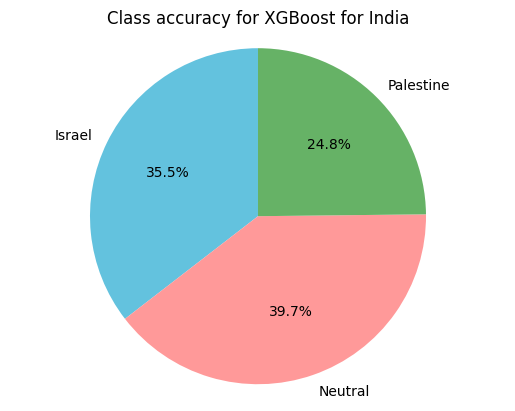

In [5]:
import matplotlib.pyplot as plt

# Accuracy values for each category
accuracies = [83.33, 93.33, 58.33]

# Labels for the categories
labels = ['Israel', 'Neutral', 'Palestine']

# Colors for each category
colors = ['#63c2de', '#ff9999', '#66b266']

# Create a pie chart
plt.pie(accuracies, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Class accuracy for XGBoost for India')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Save the pie chart as an image (e.g., PNG)
plt.savefig('overall_accuracy_pie_chart.png', dpi=300, bbox_inches='tight')

# Show the pie chart
plt.show()


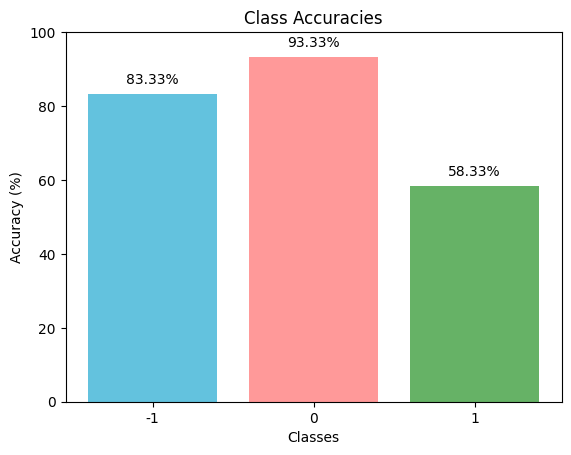

In [8]:
import matplotlib.pyplot as plt

# Class accuracies
class_accuracies = [83.33, 93.33, 58.33]

# Labels for each class
class_labels = ['-1', '0', '1']

# Create a bar chart
plt.bar(class_labels, class_accuracies, color=['#63c2de', '#ff9999', '#66b266'])
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Class Accuracies')
plt.ylim(0, 100)  # Set the y-axis limit to ensure accuracy percentages are within the range

# Display the values on top of the bars
for i, value in enumerate(class_accuracies):
    plt.text(i, value + 2, f'{value:.2f}%', ha='center', va='bottom')

# Show the bar chart
# Save the pie chart as an image (e.g., PNG)
plt.savefig('overall_accuracy_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()
